# Data Preparation

In [ ]:
!pip install segmentation-models

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import numpy as np
import glob

import numpy as np
from matplotlib import pyplot as plt
import tifffile as tiff
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU
import random
from skimage.util import view_as_windows
import imageio.v2 as imageio
from keras.models import load_model
import pydotplus
import pydot
from keras.utils import plot_model

Segmentation Models: using `keras` framework.


Labels are:  [  0  29 105 150 179 226 255]  and the counts are:  [ 410893  897513 1987169  473559     138 2169764   53668]


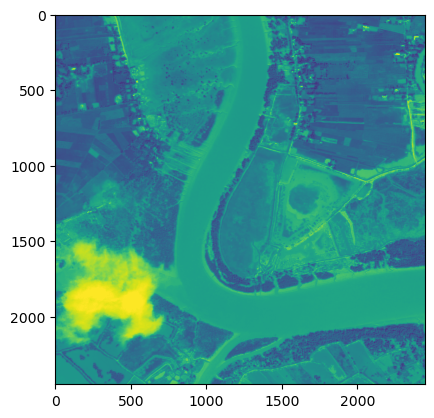

In [ ]:
#Quick understanding of the dataset
temp_img = cv2.imread(r"C:\Users\HARRISH\dataset\archive\train\sat\sat_ (8).jpg") #3 channels / spectral bands
plt.imshow(temp_img[:,:,2]) #View each channel...
temp_mask = cv2.imread(r"C:\Users\HARRISH\dataset\archive\train\mask\mask_ (8).png", cv2.IMREAD_UNCHANGED) # Load mask image as is (unchanged)
temp_mask_gray = cv2.cvtColor(temp_mask, cv2.COLOR_BGR2GRAY) # Convert to grayscale
labels, count = np.unique(temp_mask_gray, return_counts=True) # Check unique labels in grayscale mask
print("Labels are: ", labels, " and the counts are: ", count)

In [ ]:
train_img_dir = r"C:\Users\HARRISH\dataset\archive\train_256\images"
train_mask_dir = r"C:\Users\HARRISH\dataset\archive\train_256\masks"

In [ ]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [ ]:
num_images = len(os.listdir(train_img_dir))

In [ ]:
num_images

2430

In [ ]:
img_num = random.randint(0, num_images-1)
img_num

1726

In [ ]:
train_img_dir+img_list[img_num], 1

('C:\\Users\\HARRISH\\dataset\\archive\\train_256\\imagesimage_2_2_7.jpg', 1)

In [ ]:
image_path = os.path.join(train_img_dir, img_list[img_num])
if not os.path.exists(image_path):
    print(f"Error: File '{image_path}' does not exist.")
else:
    # Load the image
    img_for_plot = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if img_for_plot is None:
        print(f"Error: Unable to load image '{image_path}'")
    else:
        # Convert BGR to RGB
        img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

In [ ]:
# Construct the image path
mask_path = os.path.join(train_mask_dir, msk_list[img_num])

# Print the path for debugging
print("Mask Path:", mask_path)

# Load the image
mask_for_plot = cv2.imread(mask_path)

# Check if the image is loaded successfully
if mask_for_plot is None:
    print("Error: Unable to load the image.")
else:
    print("Image loaded successfully.")

Mask Path: C:\Users\HARRISH\dataset\archive\train_256\masks\mask_2_2_7.png
Image loaded successfully.


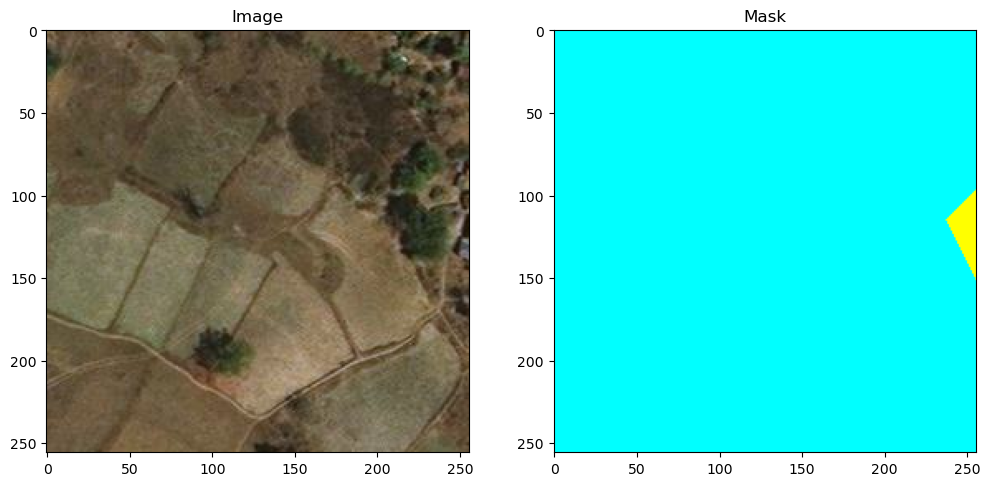

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='viridis')
plt.title('Mask')
plt.show()

In [ ]:
#import splitfolders

In [ ]:
# input_folder = r'C:\Users\HARRISH\dataset\archive\train_256'
# output_folder = r"C:\Users\HARRISH\dataset\archive\train_256\data_for_training_and_testing"

In [ ]:
#splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

# Training

In [ ]:
train_img_dir = "/content/drive/MyDrive/Deepglobe 2/train_256 (2)/data/train_images/train"
train_mask_dir = "/content/drive/MyDrive/Deepglobe 2/train_256 (2)/data/train_masks/train"

In [ ]:
img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

In [ ]:
num_images = len(os.listdir(train_img_dir))

In [ ]:
img_num = random.randint(0, num_images-1)
img_num

5344

In [ ]:
image_path = os.path.join(train_img_dir, img_list[img_num])
if not os.path.exists(image_path):
    print(f"Error: File '{image_path}' does not exist.")
else:
    # Load the image
    img_for_plot = cv2.imread(image_path)

    # Check if the image is loaded successfully
    if img_for_plot is None:
        print(f"Error: Unable to load image '{image_path}'")
    else:
        # Convert BGR to RGB
        img_for_plot = cv2.cvtColor(img_for_plot, cv2.COLOR_BGR2RGB)

In [ ]:
img_list[img_num]

'sat_ (1490).jpg'

In [ ]:
# Construct the image path
mask_path = os.path.join(train_mask_dir, msk_list[img_num])

# Print the path for debugging
print("Mask Path:", mask_path)

# Load the image
mask_for_plot = cv2.imread(mask_path)

# Check if the image is loaded successfully
if mask_for_plot is None:
    print("Error: Unable to load the image.")
else:
    print("Image loaded successfully.")

IndexError: list index out of range

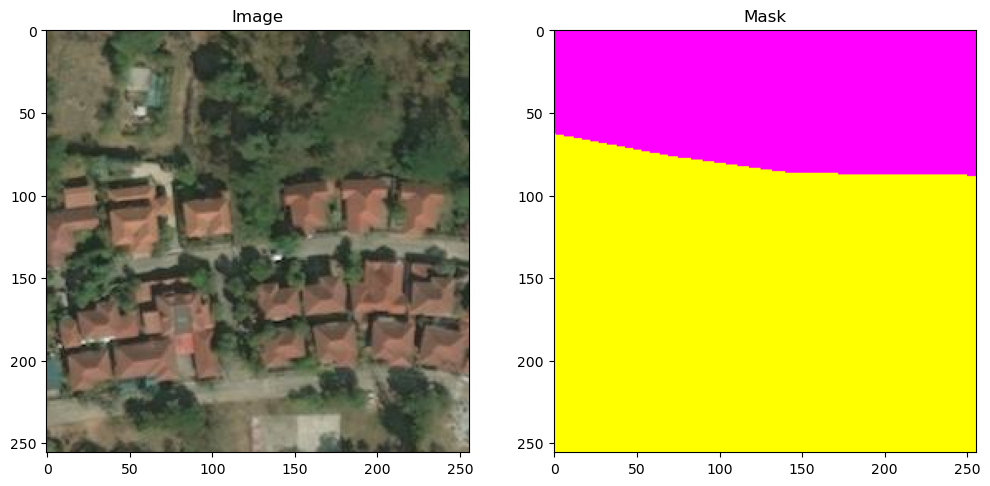

In [ ]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(img_for_plot)
plt.title('Image')
plt.subplot(122)
plt.imshow(mask_for_plot, cmap='gray')
plt.title('Mask')
plt.show()

In [ ]:
# Define Generator for images and masks so we can read them directly from the drive.

seed=24
batch_size= 16
n_classes=7

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
from keras.utils import to_categorical

In [ ]:
#Use this to preprocess input for transfer learning
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
#Define a function to perform additional preprocessing after datagen.
#For example, scale images, convert masks to categorical, etc.
def preprocess_data(img, mask, num_class):
    # Scale images
    img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
    img = preprocess_input(img)  # Preprocess based on the pretrained backbone...

    # Normalize mask values to range from 0 to num_class - 1
    mask_normalized = np.floor_divide(mask, 36.43)  # Divide by 36 since 255 / 36 = 7.083

    # Convert mask to one-hot
    mask_one_hot = to_categorical(mask_normalized, num_classes=num_class)

    return (img, mask_one_hot)

In [ ]:
#Define the generator.
#We are not doing any rotation or zoom to make sure mask values are not interpolated.
#It is important to keep pixel values in mask as 0, 1, 2, 3, .....
from tensorflow.keras.preprocessing.image import ImageDataGenerator
def trainGenerator(train_img_path, train_mask_path, num_class):

    img_data_gen_args = dict(horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

    image_datagen = ImageDataGenerator(**img_data_gen_args)
    mask_datagen = ImageDataGenerator(**img_data_gen_args)

    image_generator = image_datagen.flow_from_directory(
        train_img_path,
        class_mode = None,
        batch_size = batch_size,
        seed = seed)

    mask_generator = mask_datagen.flow_from_directory(
        train_mask_path,
        class_mode = None,
        color_mode = 'grayscale',
        batch_size = batch_size,
        seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img, mask) in train_generator:
        img, mask = preprocess_data(img, mask, num_class)
        yield (img, mask)

In [ ]:
train_img_path = "/content/drive/MyDrive/Deepglobe 2/train_256 (2)/data/train_images"
train_mask_path = "/content/drive/MyDrive/Deepglobe 2/train_256 (2)/data/train_masks"
train_img_gen = trainGenerator(train_img_path, train_mask_path, num_class=7)

In [ ]:
val_img_path = "/content/drive/MyDrive/Deepglobe 2/train_256 (2)/data/val_images"
val_mask_path = "/content/drive/MyDrive/train_256 (2)/data/val_masks/val"
val_img_gen = trainGenerator(val_img_path, val_mask_path, num_class=7)


In [ ]:
#Make sure the generator is working and that images and masks are indeed lined up.
#Verify generator.... In python 3 next() is renamed as __next__()
x, y = train_img_gen.__next__()

Found 0 images belonging to 0 classes.
Found 0 images belonging to 0 classes.


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by MinMaxScaler.

In [ ]:
for i in range(3,7):
    image = x[i]
    mask = np.argmax(y[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='viridis')
    plt.show()

IndexError: index 3 is out of bounds for axis 0 with size 0

In [ ]:
x_val, y_val = val_img_gen.__next__()

Found 0 images belonging to 1 classes.
Found 0 images belonging to 1 classes.


ValueError: Found array with 0 sample(s) (shape=(0, 3)) while a minimum of 1 is required by MinMaxScaler.

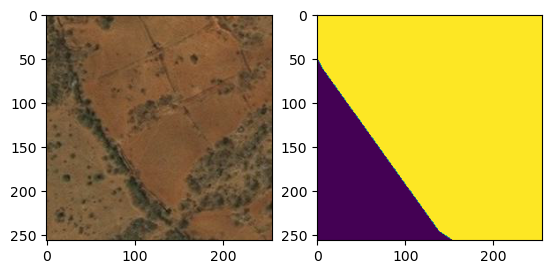

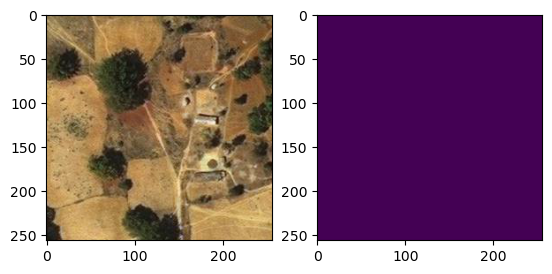

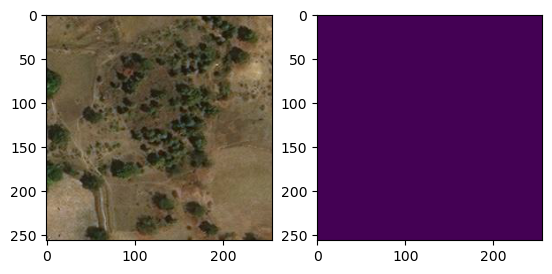

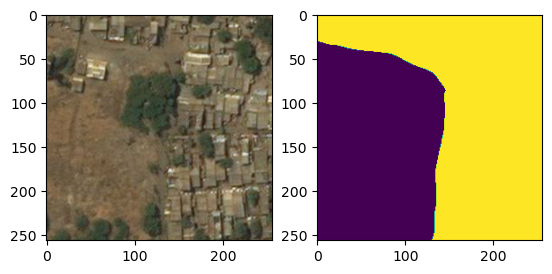

In [ ]:
for i in range(3,7):
    image = x_val[i]
    mask = np.argmax(y_val[i], axis=2)
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap='viridis')
    plt.show()

In [ ]:
#Define the model metrcis and load model.

num_train_imgs = len(os.listdir(r"C:\Users\HARRISH\dataset\archive\train_256\data\train_images\train"))
num_val_images = len(os.listdir(r"C:\Users\HARRISH\dataset\archive\train_256\data\val_images\val"))
steps_per_epoch = num_train_imgs//batch_size
val_steps_per_epoch = num_val_images//batch_size

In [ ]:
steps_per_epoch, val_steps_per_epoch

(113, 38)

In [ ]:
IMG_HEIGHT = x.shape[1]
IMG_WIDTH  = x.shape[2]
IMG_CHANNELS = x.shape[3]

In [ ]:
IMG_HEIGHT,IMG_WIDTH,IMG_CHANNELS

(256, 256, 3)

In [ ]:
n_classes = 7

In [ ]:
#Use transfer learning using pretrained encoder in the U-Net
#Define the model
# define model
model = sm.Unet(BACKBONE, encoder_weights='imagenet',
                input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS),
                classes=n_classes, activation='softmax')
model.compile('Adam', loss=sm.losses.categorical_focal_jaccard_loss, metrics=[sm.metrics.iou_score])

In [ ]:
print(model.summary())
print(model.input_shape)

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)             │ (None, 256, 256, 3)       │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn_data (BatchNormalization)  │ (None, 256, 256, 3)       │               9 │ data[0][0]                 │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d                │ (None, 262, 262, 3)       │               0 │ bn_data[0][0]              │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv0 (Conv2D)                │ (None, 128, 128, 64)      │           9,408 │ zero_padding2d[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bn0 (BatchNormalization)      │ (None, 128, 128, 64)      │             256 │ conv0[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ relu0 (Activation)            │ (None, 128, 128, 64)      │               0 │ bn0[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_1              │ (None, 130, 130, 64)      │               0 │ relu0[0][0]                │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pooling0 (MaxPooling2D)       │ (None, 64, 64, 64)        │               0 │ zero_padding2d_1[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn1              │ (None, 64, 64, 64)        │             256 │ pooling0[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu1            │ (None, 64, 64, 64)        │               0 │ stage1_unit1_bn1[0][0]     │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ zero_padding2d_2              │ (None, 66, 66, 64)        │               0 │ stage1_unit1_relu1[0][0]   │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_conv1 (Conv2D)   │ (None, 64, 64, 64)        │          36,864 │ zero_padding2d_2[0][0]     │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_bn2              │ (None, 64, 64, 64)        │             256 │ stage1_unit1_conv1[0][0]   │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ stage1_unit1_relu2            │ (None, 64, 64, 64)        │               0 │ stage1_unit1_bn2[0][0]     │
│ (Activation)                  │                           │               

 Total params: 24,457,024 (93.30 MB)

 Trainable params: 24,439,674 (93.23 MB)

 Non-trainable params: 17,350 (67.77 KB)

None
(None, 256, 256, 3)


dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.996957 to fit



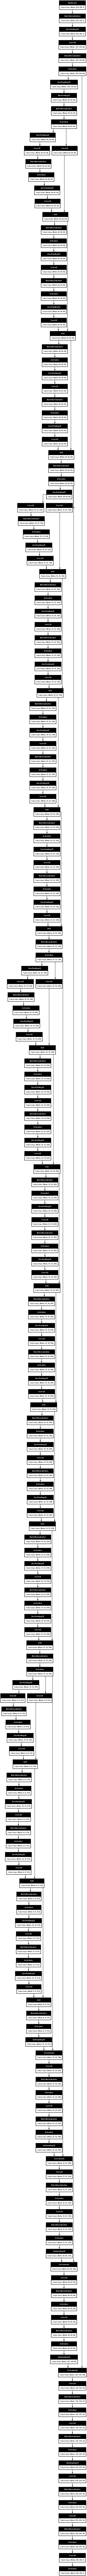

In [ ]:
dot_graph = pydot.Dot(graph_name="U-Net Model")
plot_model(model, to_file='model.png', show_shapes=True, dpi=100)

In [ ]:
dot_graph.write_png('model.png')

In [ ]:
#Train the model.
history=model.fit(train_img_gen,
          steps_per_epoch=steps_per_epoch,
          epochs=40,
          verbose=1,
          validation_data=val_img_gen,
          validation_steps=val_steps_per_epoch)

Epoch 1/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 1169s 10s/step - iou_score: 0.1904 - loss: 0.8486 - val_iou_score: 0.0769 - val_loss: 0.9869
Epoch 2/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 574s 5s/step - iou_score: 0.2837 - loss: 0.7533 - val_iou_score: 0.0719 - val_loss: 1.0371
Epoch 3/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 550s 5s/step - iou_score: 0.3073 - loss: 0.7268 - val_iou_score: 0.0706 - val_loss: 1.0291
Epoch 4/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 551s 5s/step - iou_score: 0.3225 - loss: 0.7101 - val_iou_score: 0.0854 - val_loss: 1.0050
Epoch 5/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 552s 5s/step - iou_score: 0.3238 - loss: 0.7071 - val_iou_score: 0.0709 - val_loss: 1.0369
Epoch 6/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 556s 5s/step - iou_score: 0.3349 - loss: 0.6971 - val_iou_score: 0.0478 - val_loss: 1.0625
Epoch 7/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 615s 5s/step - iou_score: 0.3087 - loss: 0.7263 - val_iou_score: 0.0858 - val_loss: 1.0728
Epoch 8/40
113/113 ━━━━━━━━━━━━━━━━━━━━ 631s 6s/step - iou_score: 0.3445 - loss: 

In [ ]:
model.save('landcover_40_epochs_RESNET_backbone_batch16.keras')

In [ ]:
# #plot the training and validation IoU and loss at each epoch
# loss = history.history['loss']
# val_loss = history.history['val_loss']
# epochs = range(1, len(loss) + 1)
# plt.plot(epochs, loss, 'y', label='Training loss')
# plt.plot(epochs, val_loss, 'r', label='Validation loss')
# plt.title('Training and validation loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

In [ ]:
# acc = history.history['iou_score']
# val_acc = history.history['val_iou_score']

In [ ]:
# plt.plot(epochs, acc, 'y', label='Training IoU')
# plt.plot(epochs, val_acc, 'r', label='Validation IoU')
# plt.title('Training and validation IoU')
# plt.xlabel('Epochs')
# plt.ylabel('IoU')
# plt.legend()
# plt.show()

In [ ]:
model = load_model("landcover_40_epochs_RESNET_backbone_batch16.keras", compile=False)

In [ ]:
test_image_batch, test_mask_batch = val_img_gen.__next__()

In [ ]:
test_image_batch

array([[[[0.24705884, 0.28627452, 0.2509804 ],
         [0.21176472, 0.2509804 , 0.21568629],
         [0.18823531, 0.227451  , 0.19215688],
         ...,
         [0.3254902 , 0.37254903, 0.29411766],
         [0.32156864, 0.36862746, 0.2901961 ],
         [0.3372549 , 0.38431376, 0.30588236]],

        [[0.26666668, 0.30588236, 0.27058825],
         [0.2509804 , 0.2901961 , 0.25490198],
         [0.23529413, 0.27450982, 0.2392157 ],
         ...,
         [0.3137255 , 0.34901962, 0.26666668],
         [0.32156864, 0.35686275, 0.27450982],
         [0.36862746, 0.4039216 , 0.32156864]],

        [[0.19607845, 0.23529413, 0.20000002],
         [0.20000002, 0.2392157 , 0.20392159],
         [0.21960786, 0.24705884, 0.21568629],
         ...,
         [0.26666668, 0.3019608 , 0.21960786],
         [0.29803923, 0.32941177, 0.24705884],
         [0.3647059 , 0.39607847, 0.3137255 ]],

        ...,

        [[0.27058825, 0.2784314 , 0.22352943],
         [0.3254902 , 0.33333334, 0.2784314 ]

In [ ]:
#Convert categorical to integer for visualization and IoU calculation
test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
test_pred_batch = model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

n_classes = 7
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Mean IoU = 0.7171486


In [ ]:
# To check all the validation batches and to get a consolidated Iou score

IOU_keras = MeanIoU(num_classes=n_classes)

for i in range(val_steps_per_epoch):
    test_image_batch, test_mask_batch = val_img_gen.__next__()

    #Predict the ground truth mask
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

    # Calculate IOU for this batch and update the metric
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
    IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
    #batch_iou = IOU_keras.result().numpy()

print("Mean IoU =", IOU_keras.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [ ]:
individual_iou_scores = []

# Iterate over all batches in the validation dataset
for _ in range(val_steps_per_epoch):
    # Initialize MeanIoU metric for each batch
    IOU_keras_batch = MeanIoU(num_classes=n_classes)

    test_image_batch, test_mask_batch = val_img_gen.__next__()

    # Predict the masks
    test_pred_batch = model.predict(test_image_batch)
    test_pred_batch_argmax = np.argmax(test_pred_batch, axis=3)

    # Calculate IOU for this batch
    test_mask_batch_argmax = np.argmax(test_mask_batch, axis=3)
    IOU_keras_batch.update_state(test_pred_batch_argmax, test_mask_batch_argmax)

    # Get the IOU score for this batch and append to the list
    batch_iou = IOU_keras_batch.result().numpy()
    individual_iou_scores.append(batch_iou)

# Print individual IOU scores
for i, iou in enumerate(individual_iou_scores):
    print(f"IOU for batch {i+1}: {iou}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

In [ ]:
individual_iou_scores

[0.6363117,
 0.83475286,
 0.558498,
 0.6105108,
 0.6515223,
 0.5839759,
 0.5855523,
 0.49716502,
 0.45225745,
 0.6109281,
 0.6637007,
 0.6343175,
 0.5309948,
 0.5770159,
 0.83150566,
 0.54894644,
 0.73537725,
 0.4307108,
 0.50141996,
 0.774335,
 0.67945766,
 0.72343993,
 0.5910739,
 0.47135165,
 0.6618491,
 0.6812786,
 0.6059364,
 0.64643335,
 0.31625164,
 0.4747612,
 0.62331265,
 0.64075625,
 0.66726816,
 0.32384023,
 0.5101193,
 0.60428035,
 0.6406456,
 0.58379424]

In [ ]:
overall_iou = np.mean(individual_iou_scores)

In [ ]:
overall_iou

0.5972539

In [ ]:
# Find the index of the batch with the highest IOU score
best_batch_index = np.argmax(individual_iou_scores)

# Load only the batch with the highest IOU score
best_image_batch, best_mask_batch = None, None
for i in range(best_batch_index + 1):
    best_image_batch, best_mask_batch = val_img_gen.__next__()

# Now you have the best_image_batch and best_mask_batch corresponding to the batch with the highest IOU score


In [ ]:
#Convert categorical to integer for visualization and IoU calculation (of best batches only)
best_mask_batch_argmax = np.argmax(best_mask_batch, axis=3)
best_pred_batch = model.predict(best_image_batch)
best_pred_batch_argmax = np.argmax(best_pred_batch, axis=3)

n_classes = 7
IOU_keras = MeanIoU(num_classes=n_classes)
IOU_keras.update_state(best_pred_batch_argmax, best_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Mean IoU = 0.68414694


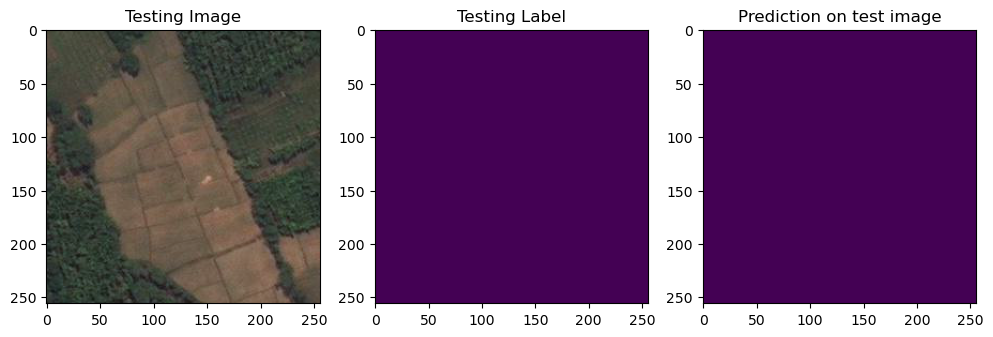

In [ ]:
#View a few images, masks and corresponding predictions.
img_num = random.randint(0, test_image_batch.shape[0]-1)

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(best_image_batch[img_num])
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(best_mask_batch_argmax[img_num])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(best_pred_batch_argmax[img_num])
plt.show()

In [ ]:
from smooth_tiled_predictions import predict_img_with_smooth_windowing

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)

In [ ]:
img = cv2.imread(r"C:\Users\HARRISH\dataset\archive\train\sat\sat_ (8).jpg")  #N-34-66-C-c-4-3.tif, N-34-97-D-c-2-4.tif
input_img = scaler.fit_transform(img.reshape(-1, img.shape[-1])).reshape(img.shape)
input_img = preprocess_input(input_img)


In [ ]:
original_mask = cv2.imread(r"C:\Users\HARRISH\dataset\archive\train\mask\mask_ (8).png")
original_mask = original_mask[:,:,0]  #Use only single channel...
#original_mask = to_categorical(original_mask, num_classes=n_classes)

In [ ]:
patch_size = 256
n_classes = 7

In [ ]:
#Predict using smooth blending

# Use the algorithm. The `pred_func` is passed and will process all the image 8-fold by tiling small patches with overlap, called once with all those image as a batch outer dimension.
# Note that model.predict(...) accepts a 4D tensor of shape (batch, x, y, nb_channels), such as a Keras model.
predictions_smooth = predict_img_with_smooth_windowing(
    input_img,
    window_size=patch_size,
    subdivisions=2,  # Minimal amount of overlap for windowing. Must be an even number.
    nb_classes=n_classes,
    pred_func=(
        lambda img_batch_subdiv: model.predict((img_batch_subdiv))
    )
)


final_prediction = np.argmax(predictions_smooth, axis=2)

#Save prediction and original mask for comparison
plt.imsave(r"C:\Users\HARRISH\dataset\archive\test\test_images\sat_ (8).jpg", final_prediction)
plt.imsave(r"C:\Users\HARRISH\dataset\archive\test\test_images\mask_ (8).png", original_mask)

  0%|                                                                                            | 0/8 [00:00<?, ?it/s]

 8/13 ━━━━━━━━━━━━━━━━━━━━ 12s 3s/step

  0%|                                                                                            | 0/8 [00:31<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 12))
plt.subplot(221)
plt.title('Testing Image')
plt.imshow(img)
plt.subplot(222)
plt.title('Testing Label')
plt.imshow(original_mask)
plt.subplot(223)
plt.title('Prediction with smooth blending')
plt.imshow(final_prediction)
plt.show()
